# Taksit 

Selvitetään, onko ollut vaikutusta auton hintaan, jos auto on ollut aiemmin taksikäytössä. 



## CRISP-DM vaiheet 2 ja 3: Datan ymmärtäminen ja esikäsittely    

Tässä vaiheessa ladataan käytettävä CSV-aineisto, ja puhdistetaan ja muokataan se eheäksi ja tarkoituksenmukaiseksi myöhempää analyysi- ja mallinnusvaihetta varten. Aloitetaan lataamalla aineisto ja siitä tehtävän kannalta relevantit sarakkeet Ladataan aineistosta sarakkeet *'make_name'* (merkki), *'model_name'* (mallin nimi), *'mileage'* (mittarilukema), *'year'* (käyttöönottovuosi), *'price'* (myyntihinta), *'isCab'* (onko auto ollut taksikäytössä), *'daysonmarket'* (montako päivää auto oli myynnissä) ja *'has_accidents'* (onko auto joutunut onnettomuuteen) datakehikkoon *'df'*:

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
# Tiedoston polku: 
file_path = '/Volumes/AIDA/AIDA-projekti/used_cars_data.csv' 

# Valitut sarakkeet:
sarakkeet = ['make_name', 'model_name', 'mileage', 'year', 'price', 'isCab', 'daysonmarket', 'has_accidents']

# Luetaan aineistosta vain halutut sarakkeet datakehikkoon:
df = pd.read_csv(file_path, usecols = sarakkeet) 

Tutkitaan saatua datakehikkoa.

In [93]:
df.sample(10)

,daysonmarket,has_accidents,isCab,make_name,mileage,model_name,price,year
672257,110,False,False,Ford,35169.0,Focus,11995.0,2017
1124718,18,NaN,NaN,GMC,0.0,Sierra 1500,69720.0,2020
2359766,16,NaN,NaN,Lexus,3.0,RX,53845.0,2020
1621914,5,False,False,Kia,13748.0,Soul,17911.0,2017
1017058,186,True,True,Hyundai,61801.0,Accent,8799.0,2017
1384513,4,False,True,Ford,24556.0,Fusion Hybrid,18988.0,2019
2630203,59,False,False,Honda,35125.0,Odyssey,27988.0,2017
1390211,216,NaN,NaN,Mazda,10.0,CX-5,25844.0,2020
1700102,12,NaN,NaN,Nissan,0.0,Murano,35212.0,2020
1446141,39,True,True,Hyundai,34520.0,Elantra,16995.0,2019


### Uuden sarakkeen luominen

Yhdistetään *'make_name'* ja *'model_name'* yhdeksi sarakkeeksi *'name'*:

In [95]:
df['name'] = df['make_name'] + " " + df['model_name']
df.head()

,daysonmarket,has_accidents,isCab,make_name,mileage,model_name,price,year,name
0,522,NaN,NaN,Jeep,7.0,Renegade,23141.0,2019,Jeep Renegade
1,207,NaN,NaN,Land Rover,8.0,Discovery Sport,46500.0,2020,Land Rover Discovery Sport
2,1233,False,False,Subaru,NaN,WRX STI,46995.0,2016,Subaru WRX STI
3,196,NaN,NaN,Land Rover,11.0,Discovery,67430.0,2020,Land Rover Discovery
4,137,NaN,NaN,Land Rover,7.0,Discovery Sport,48880.0,2020,Land Rover Discovery Sport


### Tyhjien arvojen käsittely

Tässä kysymyksessä on olennaista tietää, onko auto ollut taksikäytössä. Tutkitaan siis ensimmäiseksi, onko sarakkeessa *'isCab'* tyhjiä arvoja, ja poistetaan tarvittaessa tällaiset rivit. 

In [96]:
df['isCab'].unique()

array([nan, False, True], dtype=object)

In [97]:
# Tarkastetaan, montako tyhjää arvoa sarakkeessa 'isCab' on:
df['isCab'].isna().sum()

1426595

In [98]:
# Poistetaan sarakkeessa 'isCab' tyhjän arvon sisältävät rivit:
df.dropna(subset=['isCab'], inplace=True)

# Tarkastetaan uudelleen tyhjien arvojen määrät sarakkeittain:
df.isna().sum()

daysonmarket         0
has_accidents        0
isCab                0
make_name            0
mileage          19390
model_name           0
price                0
year                 0
name                 0
dtype: int64

Aineisto sisältää yhä tyhjiä arvoja sarakkeessa *'mileage'*. Sopivia keskilukuja näiden korvaamiseksi on vaikea päätellä, joten poistetaan myös nämä rivit.

In [99]:
df.dropna(subset=['mileage'], inplace=True)

df.isna().sum()

daysonmarket     0
has_accidents    0
isCab            0
make_name        0
mileage          0
model_name       0
price            0
year             0
name             0
dtype: int64

### Tietotyyppien tarkastelu

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1554055 entries, 5 to 3000039
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   daysonmarket   1554055 non-null  int64  
 1   has_accidents  1554055 non-null  object 
 2   isCab          1554055 non-null  object 
 3   make_name      1554055 non-null  object 
 4   mileage        1554055 non-null  float64
 5   model_name     1554055 non-null  object 
 6   price          1554055 non-null  float64
 7   year           1554055 non-null  int64  
 8   name           1554055 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 118.6+ MB


Aineistossa on yhä liki 1,6 miljoonaa riviä, kun siitä on poistettu tyhjiä arvoja sisältävät rivit.   

Muutetaan seuraavaksi *'object'*-tyypin sarakkeiden *'has_accidents'* ja *'isCab'* tietotyypiksi *'Boolean'*:

In [101]:
df['isCab'].unique()

array([False, True], dtype=object)

In [102]:
df['isCab'].unique()

array([False, True], dtype=object)

In [103]:
df['has_accidents'] = df['has_accidents'].astype(bool)
df['isCab'] = df['isCab'].astype(bool)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1554055 entries, 5 to 3000039
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   daysonmarket   1554055 non-null  int64  
 1   has_accidents  1554055 non-null  bool   
 2   isCab          1554055 non-null  bool   
 3   make_name      1554055 non-null  object 
 4   mileage        1554055 non-null  float64
 5   model_name     1554055 non-null  object 
 6   price          1554055 non-null  float64
 7   year           1554055 non-null  int64  
 8   name           1554055 non-null  object 
dtypes: bool(2), float64(2), int64(2), object(3)
memory usage: 97.8+ MB


### Identtisten rivien poisto 

Jos datassa on identtisiä rivejä, poistetaan ne.

In [106]:
df1 = df.drop_duplicates()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1551707 entries, 5 to 3000039
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   daysonmarket   1551707 non-null  int64  
 1   has_accidents  1551707 non-null  bool   
 2   isCab          1551707 non-null  bool   
 3   make_name      1551707 non-null  object 
 4   mileage        1551707 non-null  float64
 5   model_name     1551707 non-null  object 
 6   price          1551707 non-null  float64
 7   year           1551707 non-null  int64  
 8   name           1551707 non-null  object 
dtypes: bool(2), float64(2), int64(2), object(3)
memory usage: 97.7+ MB


In [122]:
df = df1
df.head()

,daysonmarket,has_accidents,isCab,make_name,mileage,model_name,price,year,name
5,242,False,False,Land Rover,12.0,Range Rover Velar,66903.0,2020,Land Rover Range Rover Velar
9,510,False,False,Land Rover,254.0,Range Rover Evoque,84399.0,2020,Land Rover Range Rover Evoque
10,1252,False,False,Alfa Romeo,301.0,4C,97579.0,2015,Alfa Romeo 4C
12,1233,False,False,BMW,6903.0,3 Series,58995.0,2016,BMW 3 Series
36,33,False,False,Hyundai,30707.0,Elantra,13324.0,2017,Hyundai Elantra


### Aineiston rajaaminen 

Katsotaan ensin, kuinka moni aineiston autoista on ollut taksi- ja ei-taksikäytössä:

In [123]:
df['isCab'].value_counts()

isCab
False    1265950
True      285757
Name: count, dtype: int64

Tässä tehtävässä ollaan kiinnostuneita vain niistä automalleista, joita on käytetty sekä takseina että ei-takseina. Rajataan aineistoa siten, että se kattaa vain ne automallit (*'name'*), jotka ovat olleet sekä taksikäytössä että ei-taksikäytössä.    

Aloitetaan tallentamalla uniikit automallit muuttujaan *'uniikit_autot'*, ja käydään sitä läpi malli kerrallaan. Tarkastetaan, onko kyseinen automalli ollut sekä taksi- että ei-taksikäytössä, ja tallennetaan tällaiset automallit listaan *'autolista'*:

In [133]:
uniikit_autot = df['name'].unique() 

autolista = []

for malli in uniikit_autot:
    taksi = df[(df['name'] == malli) & (df['isCab'] == True)]
    eitaksi = df[(df['name'] == malli) & (df['isCab'] == False)]

    if len(taksi) > 0 and len(eitaksi) > 0:
        autolista.append(malli)

In [134]:
len(autolista)

578

In [135]:
df['name'].nunique()

1426

Sopivia automalleja on 578, kun niitä datakehikossa *'df'* on kaikkiaan 1426. Suodatetaan datakehikkoa siten, että vain *'autolista'*:n mukaiset mallit ovat mukana:

In [136]:
autot_df = df[df['name'].isin(autolista)]

In [137]:
autot_df.head()

,daysonmarket,has_accidents,isCab,make_name,mileage,model_name,price,year,name
5,242,False,False,Land Rover,12.0,Range Rover Velar,66903.0,2020,Land Rover Range Rover Velar
9,510,False,False,Land Rover,254.0,Range Rover Evoque,84399.0,2020,Land Rover Range Rover Evoque
12,1233,False,False,BMW,6903.0,3 Series,58995.0,2016,BMW 3 Series
36,33,False,False,Hyundai,30707.0,Elantra,13324.0,2017,Hyundai Elantra
38,55,False,True,Chevrolet,42394.0,Malibu,14639.0,2018,Chevrolet Malibu


In [129]:
autot_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1494497 entries, 5 to 3000039
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   daysonmarket   1494497 non-null  int64  
 1   has_accidents  1494497 non-null  bool   
 2   isCab          1494497 non-null  bool   
 3   make_name      1494497 non-null  object 
 4   mileage        1494497 non-null  float64
 5   model_name     1494497 non-null  object 
 6   price          1494497 non-null  float64
 7   year           1494497 non-null  int64  
 8   name           1494497 non-null  object 
dtypes: bool(2), float64(2), int64(2), object(3)
memory usage: 94.1+ MB


Muutetaan vielä boolean-tietotyypin sarakkeet *'has_accidents'* ja *'isCab'* numeerisiksi koneoppimismalleja varten:

In [140]:
autot_df.loc[:, 'has_accidents'] = autot_df['has_accidents'].astype(int)
autot_df.loc[:, 'isCab'] = autot_df['isCab'].astype(int)

In [141]:
autot_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1494497 entries, 5 to 3000039
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   daysonmarket   1494497 non-null  int64  
 1   has_accidents  1494497 non-null  int64  
 2   isCab          1494497 non-null  int64  
 3   make_name      1494497 non-null  object 
 4   mileage        1494497 non-null  float64
 5   model_name     1494497 non-null  object 
 6   price          1494497 non-null  float64
 7   year           1494497 non-null  int64  
 8   name           1494497 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 114.0+ MB


Aineisto on nyt valmis jatkokäyttöä varten. Siinä on mukana noin 1,5 miljoonaa datariviä, eli suunnilleen puolet alkuperäisestä aineistosta. Tutustutaan seuraavaksi tarkemmin datakehikkoon *'autot_df'* tilastollisten tunnuslukujen ja visualisointien avulla.   

### Tilastolliset tunnusluvut

In [144]:
autot_df.describe()

,daysonmarket,has_accidents,isCab,mileage,price,year
count,1.494497e+06,1.494497e+06,1.494497e+06,1.494497e+06,1.494497e+06,1.494497e+06
mean,5.709698e+01,1.555861e-01,1.912061e-01,5.718882e+04,2.260863e+04,2.015717e+03
std,1.008197e+02,3.624626e-01,3.932511e-01,4.777695e+04,1.486099e+04,4.212852e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.650000e+02,1.939000e+03
25%,1.300000e+01,0.000000e+00,0.000000e+00,2.394500e+04,1.385000e+04,2.014000e+03
50%,2.900000e+01,0.000000e+00,0.000000e+00,4.024600e+04,1.959000e+04,2.017000e+03
75%,5.700000e+01,0.000000e+00,0.000000e+00,8.234200e+04,2.897500e+04,2.018000e+03
max,3.599000e+03,1.000000e+00,1.000000e+00,6.318350e+05,2.698500e+06,2.021000e+03


Näyttää siltä, että aineistossa on mukana uusia autoja. 

In [146]:
autot_df.columns

Index(['daysonmarket', 'has_accidents', 'isCab', 'make_name', 'mileage',
       'model_name', 'price', 'year', 'name'],
      dtype='object')

### Hintojen jakaumat 

Tarkastellaan seuraavaksi, kuinka hinnat jakautuvat taksien ja ei-taksien kesken. Käytetään tässä boxplot-kaaviota:

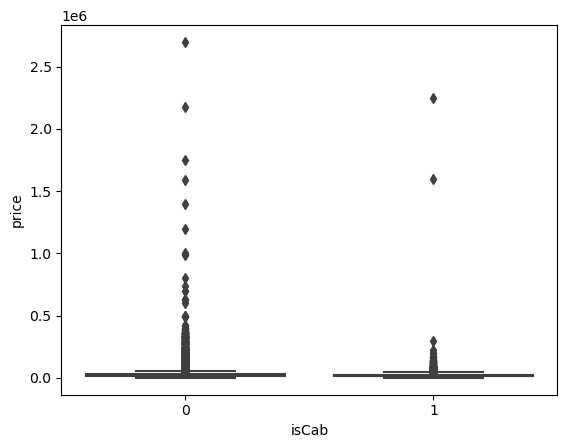

In [143]:
sns.boxplot(x = 'isCab', y = 'price', data = autot_df)
plt.show()

Kaaviosta voidaan päätellä, että taksikäytössä olleiden autojen hinta vaihtelee vähemmän, kuin ei-taksikäytössä olleiden autojen, joilla jakauman häntä kalliimpaan suuntaan on paljon takseina toimineita autoja pidempi. Joidenkin takseina toimineiden autojen hinta on muita takseja merkittävästi korkeampi, muttei siltikään yhtä korkea, kuin ei-takseina toimineilla. 

### Aineiston tallentaminen tiedostoon

Data on nyt valmis analyysiä varten. Tallennetaan se myöhempää käyttöä varten uudeksi CSV-tiedostoksi *'taksi_data.csv'*:

In [39]:
#df.to_csv("taksi_data.csv", index = False)

## CRISP-DM vaihe 4: Mallinnus

### Korrelaatiomatriisi 



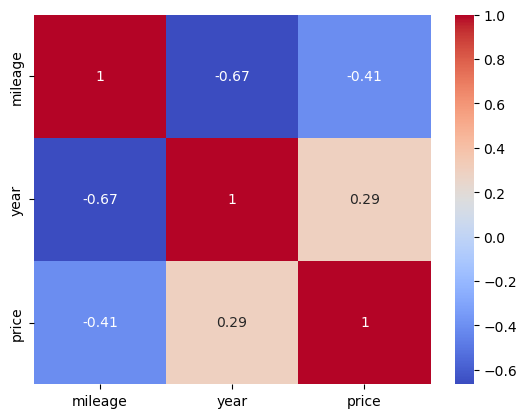

In [74]:
# Korrelaatiomatriisi sarakkeista 'mileage', 'year', ja 'price':
correlation_matrix = df[['mileage', 'year', 'price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()